In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_probability as tfp

print(tf.__version__)
print('Listing all GPU resources:')
print(tf.config.experimental.list_physical_devices('GPU'))
print()
import tensorflow.keras as keras
print(tfp.__version__)
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pickle
import os
import sys
import git
import importlib.util
from tqdm import trange

2.2.0
Listing all GPU resources:
[]

0.10.0


In [2]:
LAYER_NAME = 'linear_gaussian'
ROOT_PATH = git.Repo("", search_parent_directories=True).git.rev_parse("--show-toplevel")
DATA_PATH = ROOT_PATH + "/data/"
SAVE_PATH = "bayesian_model.h5"
N_DATA = 16
X_DIM = 2
EPOCHS = 1000
VERBOSE = 2
N_SAMPLES = 1000

PRIOR_MU = 0
PRIOR_STDDEV = 10
LIKELIHOOD_STDDEV = 0.1

np.random.seed(1)

In [3]:
X = np.random.rand(N_DATA, X_DIM, )
y = (3*X[:, 0].reshape(-1, 1) 
     + 2*X[:, 1].reshape(-1, 1) 
     + np.random.normal(0, LIKELIHOOD_STDDEV, N_DATA).reshape(-1, 1))

print("-" * 30)
print("Loading training and testing data...")
print("-" * 30)

print('X:', X.shape)
print('y: ', y.shape)

Xy = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X),
                                tf.data.Dataset.from_tensor_slices(y))).cache()


------------------------------
Loading training and testing data...
------------------------------
X: (16, 2)
y:  (16, 1)


In [4]:
def make_model():

    class KLDivergence:
        def __init__(self, q_dist, p_dist):
            self.q_dist = q_dist
            self.p_dist = p_dist
        def call(self):
            return tfp.distributions.kl_divergence(self.q_dist, self.p_dist)
    
    likelihood_fn = tfp.distributions.MultivariateNormalDiag(np.zeros(N_DATA).astype(np.float32), 
                                                             scale_identity_multiplier=LIKELIHOOD_STDDEV)
    
    def gaussian_likelihood(y, y_pred):
        return -likelihood_fn.log_prob(y-y_pred)
    

    posterior_fn = tfp.layers.default_mean_field_normal_fn(
              loc_initializer=tf.random_normal_initializer(
                  mean=PRIOR_MU, stddev=0.05),
              untransformed_scale_initializer=tf.random_normal_initializer(
                  mean=np.log(np.exp(1e-3) - 1), stddev=0.05))

    def prior_fn(dtype, shape, name, trainable, add_variable_fn):
        dist = tfp.distributions.Normal(loc=PRIOR_MU*tf.ones(shape, dtype), 
                                 scale=PRIOR_STDDEV*tf.ones(shape, dtype))
        multivar_dist = tfp.distributions.Independent(dist, reinterpreted_batch_ndims=tf.size(dist.batch_shape_tensor()))

        return multivar_dist

    flipout_params = dict(kernel_prior_fn=prior_fn,
                          bias_prior_fn=prior_fn,
                          kernel_posterior_fn=posterior_fn,
                          bias_posterior_fn=posterior_fn,
                          kernel_divergence_fn=None,
                          bias_divergence_fn=None)

    input_layer = keras.layers.Input(shape=(X_DIM), name="input_layer")

    output_layer = tfp.layers.DenseFlipout(1, name='dense_layer', **flipout_params)(input_layer)
    
    print()
    print('Input size:', input_layer.shape)
    print('Output size:', output_layer.shape)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer,
                               name = 'model_' + LAYER_NAME)

    for layer in model.layers:
        if type(layer) == tfp.python.layers.dense_variational.DenseFlipout:
            layer.add_loss(KLDivergence(layer.kernel_posterior, layer.kernel_prior).call)
            layer.add_loss(KLDivergence(layer.bias_posterior, layer.bias_prior).call)

    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=2e-2),
                  loss=gaussian_likelihood,
                  metrics=[gaussian_likelihood],
                  )

    return model

In [5]:
print("-" * 30)
print("Constructing model...")
print("-" * 30)
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = make_model()

print('Model summary:')
print(model.summary())

print('Model losses:')
print(model.losses)

print("-" * 30)
print("Fitting model with training data ...")
print("-" * 30)

print("Training the model started at {}".format(datetime.datetime.now()))
start_time = time.time()

#Train the model
history = model.fit(Xy.batch(N_DATA).repeat(32).unbatch().batch(32*N_DATA),
                    epochs=EPOCHS, verbose=VERBOSE,
                    batch_size=N_DATA)

print("Total time elapsed for training = {} seconds".format(time.time() - start_time))
print("Training finished at {}".format(datetime.datetime.now()))


# Save the model
# serialize weights to HDF5
model.save_weights(SAVE_PATH)

------------------------------
Constructing model...
------------------------------
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Instructions for updating:
Please use `layer.add_weight` method instead.

Input size: (None, 2)
Output size: (None, 1)
Model summary:
Model: "model_linear_gaussian"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense_layer (DenseFlipout)   (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
None
Model losses:
[<tf.Tensor: shape=(), dtype=float32, numpy=17.416142>, <tf.Tensor: shape=(), dtype=float32, numpy=8.7407875>]
------------------------------
Fitting model with training data

Epoch 92/1000
1/1 - 0s - gaussian_likelihood: 314.2064 - loss: 336.1900
Epoch 93/1000
1/1 - 0s - gaussian_likelihood: 310.9346 - loss: 332.8694
Epoch 94/1000
1/1 - 0s - gaussian_likelihood: 307.3300 - loss: 329.2201
Epoch 95/1000
1/1 - 0s - gaussian_likelihood: 303.9968 - loss: 325.8392
Epoch 96/1000
1/1 - 0s - gaussian_likelihood: 301.1711 - loss: 322.9656
Epoch 97/1000
1/1 - 0s - gaussian_likelihood: 297.8438 - loss: 319.5944
Epoch 98/1000
1/1 - 0s - gaussian_likelihood: 295.2667 - loss: 316.9703
Epoch 99/1000
1/1 - 0s - gaussian_likelihood: 292.2905 - loss: 313.9506
Epoch 100/1000
1/1 - 0s - gaussian_likelihood: 289.5051 - loss: 311.1196
Epoch 101/1000
1/1 - 0s - gaussian_likelihood: 286.1442 - loss: 307.7116
Epoch 102/1000
1/1 - 0s - gaussian_likelihood: 284.5015 - loss: 306.0132
Epoch 103/1000
1/1 - 0s - gaussian_likelihood: 281.8681 - loss: 303.3336
Epoch 104/1000
1/1 - 0s - gaussian_likelihood: 279.6608 - loss: 301.0774
Epoch 105/1000
1/1 - 0s - gaussian_likelihood: 277.2069 - l

Epoch 205/1000
1/1 - 0s - gaussian_likelihood: 138.4743 - loss: 155.3819
Epoch 206/1000
1/1 - 0s - gaussian_likelihood: 134.1426 - loss: 151.0760
Epoch 207/1000
1/1 - 0s - gaussian_likelihood: 133.9066 - loss: 150.8053
Epoch 208/1000
1/1 - 0s - gaussian_likelihood: 135.2636 - loss: 152.1494
Epoch 209/1000
1/1 - 0s - gaussian_likelihood: 130.8101 - loss: 147.7177
Epoch 210/1000
1/1 - 0s - gaussian_likelihood: 127.5548 - loss: 144.4284
Epoch 211/1000
1/1 - 0s - gaussian_likelihood: 129.6106 - loss: 146.4375
Epoch 212/1000
1/1 - 0s - gaussian_likelihood: 129.6712 - loss: 146.4727
Epoch 213/1000
1/1 - 0s - gaussian_likelihood: 125.1009 - loss: 141.8823
Epoch 214/1000
1/1 - 0s - gaussian_likelihood: 124.2600 - loss: 140.9943
Epoch 215/1000
1/1 - 0s - gaussian_likelihood: 124.3852 - loss: 141.0895
Epoch 216/1000
1/1 - 0s - gaussian_likelihood: 126.2711 - loss: 142.9394
Epoch 217/1000
1/1 - 0s - gaussian_likelihood: 120.1231 - loss: 136.8277
Epoch 218/1000
1/1 - 0s - gaussian_likelihood: 119.

Epoch 320/1000
1/1 - 0s - gaussian_likelihood: 38.5245 - loss: 53.7107
Epoch 321/1000
1/1 - 0s - gaussian_likelihood: 41.4230 - loss: 56.5792
Epoch 322/1000
1/1 - 0s - gaussian_likelihood: 37.6565 - loss: 52.8278
Epoch 323/1000
1/1 - 0s - gaussian_likelihood: 38.0719 - loss: 53.2157
Epoch 324/1000
1/1 - 0s - gaussian_likelihood: 37.9225 - loss: 53.0427
Epoch 325/1000
1/1 - 0s - gaussian_likelihood: 40.8193 - loss: 55.9139
Epoch 326/1000
1/1 - 0s - gaussian_likelihood: 39.7853 - loss: 54.8883
Epoch 327/1000
1/1 - 0s - gaussian_likelihood: 37.1862 - loss: 52.2863
Epoch 328/1000
1/1 - 0s - gaussian_likelihood: 35.2649 - loss: 50.3475
Epoch 329/1000
1/1 - 0s - gaussian_likelihood: 36.8031 - loss: 51.8658
Epoch 330/1000
1/1 - 0s - gaussian_likelihood: 35.3986 - loss: 50.4510
Epoch 331/1000
1/1 - 0s - gaussian_likelihood: 34.5403 - loss: 49.5721
Epoch 332/1000
1/1 - 0s - gaussian_likelihood: 32.0326 - loss: 47.0519
Epoch 333/1000
1/1 - 0s - gaussian_likelihood: 31.7773 - loss: 46.7594
Epoch 

Epoch 436/1000
1/1 - 0s - gaussian_likelihood: 0.9359 - loss: 15.9273
Epoch 437/1000
1/1 - 0s - gaussian_likelihood: -3.1192e-01 - loss: 14.7029
Epoch 438/1000
1/1 - 0s - gaussian_likelihood: 1.2558 - loss: 16.2699
Epoch 439/1000
1/1 - 0s - gaussian_likelihood: 3.3227 - loss: 18.3364
Epoch 440/1000
1/1 - 0s - gaussian_likelihood: -2.3508e+00 - loss: 12.6921
Epoch 441/1000
1/1 - 0s - gaussian_likelihood: 1.7545 - loss: 16.7811
Epoch 442/1000
1/1 - 0s - gaussian_likelihood: 2.1920 - loss: 17.2235
Epoch 443/1000
1/1 - 0s - gaussian_likelihood: -7.9729e-01 - loss: 14.2499
Epoch 444/1000
1/1 - 0s - gaussian_likelihood: -8.7822e-01 - loss: 14.1655
Epoch 445/1000
1/1 - 0s - gaussian_likelihood: -1.9048e+00 - loss: 13.1339
Epoch 446/1000
1/1 - 0s - gaussian_likelihood: -2.5755e+00 - loss: 12.4513
Epoch 447/1000
1/1 - 0s - gaussian_likelihood: -2.9885e+00 - loss: 12.0157
Epoch 448/1000
1/1 - 0s - gaussian_likelihood: -1.3871e+00 - loss: 13.5926
Epoch 449/1000
1/1 - 0s - gaussian_likelihood: -1.

Epoch 547/1000
1/1 - 0s - gaussian_likelihood: -1.1792e+01 - loss: 3.4803
Epoch 548/1000
1/1 - 0s - gaussian_likelihood: -1.3471e+01 - loss: 1.8052
Epoch 549/1000
1/1 - 0s - gaussian_likelihood: -1.3714e+01 - loss: 1.5489
Epoch 550/1000
1/1 - 0s - gaussian_likelihood: -1.3641e+01 - loss: 1.6053
Epoch 551/1000
1/1 - 0s - gaussian_likelihood: -1.0012e+01 - loss: 5.2216
Epoch 552/1000
1/1 - 0s - gaussian_likelihood: -1.2427e+01 - loss: 2.8375
Epoch 553/1000
1/1 - 0s - gaussian_likelihood: -1.3187e+01 - loss: 2.0767
Epoch 554/1000
1/1 - 0s - gaussian_likelihood: -1.4148e+01 - loss: 1.1043
Epoch 555/1000
1/1 - 0s - gaussian_likelihood: -1.3352e+01 - loss: 1.8806
Epoch 556/1000
1/1 - 0s - gaussian_likelihood: -1.1609e+01 - loss: 3.6118
Epoch 557/1000
1/1 - 0s - gaussian_likelihood: -1.3539e+01 - loss: 1.6924
Epoch 558/1000
1/1 - 0s - gaussian_likelihood: -1.3227e+01 - loss: 1.9954
Epoch 559/1000
1/1 - 0s - gaussian_likelihood: -1.4066e+01 - loss: 1.1511
Epoch 560/1000
1/1 - 0s - gaussian_lik

Epoch 655/1000
1/1 - 0s - gaussian_likelihood: -1.4998e+01 - loss: 0.3822
Epoch 656/1000
1/1 - 0s - gaussian_likelihood: -1.7169e+01 - loss: -1.7763e+00
Epoch 657/1000
1/1 - 0s - gaussian_likelihood: -1.5224e+01 - loss: 0.1531
Epoch 658/1000
1/1 - 0s - gaussian_likelihood: -1.6326e+01 - loss: -9.4519e-01
Epoch 659/1000
1/1 - 0s - gaussian_likelihood: -1.6574e+01 - loss: -1.1992e+00
Epoch 660/1000
1/1 - 0s - gaussian_likelihood: -1.6460e+01 - loss: -1.0951e+00
Epoch 661/1000
1/1 - 0s - gaussian_likelihood: -1.5709e+01 - loss: -3.5346e-01
Epoch 662/1000
1/1 - 0s - gaussian_likelihood: -1.6592e+01 - loss: -1.2358e+00
Epoch 663/1000
1/1 - 0s - gaussian_likelihood: -1.6689e+01 - loss: -1.3437e+00
Epoch 664/1000
1/1 - 0s - gaussian_likelihood: -1.4163e+01 - loss: 1.1695
Epoch 665/1000
1/1 - 0s - gaussian_likelihood: -1.7142e+01 - loss: -1.7828e+00
Epoch 666/1000
1/1 - 0s - gaussian_likelihood: -1.6265e+01 - loss: -9.2184e-01
Epoch 667/1000
1/1 - 0s - gaussian_likelihood: -1.6570e+01 - loss: 

Epoch 761/1000
1/1 - 0s - gaussian_likelihood: -1.7938e+01 - loss: -2.5432e+00
Epoch 762/1000
1/1 - 0s - gaussian_likelihood: -1.6601e+01 - loss: -1.2142e+00
Epoch 763/1000
1/1 - 0s - gaussian_likelihood: -1.7208e+01 - loss: -1.8151e+00
Epoch 764/1000
1/1 - 0s - gaussian_likelihood: -1.7416e+01 - loss: -2.0241e+00
Epoch 765/1000
1/1 - 0s - gaussian_likelihood: -1.4901e+01 - loss: 0.4838
Epoch 766/1000
1/1 - 0s - gaussian_likelihood: -1.7241e+01 - loss: -1.8306e+00
Epoch 767/1000
1/1 - 0s - gaussian_likelihood: -1.4254e+01 - loss: 1.1517
Epoch 768/1000
1/1 - 0s - gaussian_likelihood: -1.7296e+01 - loss: -1.8589e+00
Epoch 769/1000
1/1 - 0s - gaussian_likelihood: -1.7041e+01 - loss: -1.6078e+00
Epoch 770/1000
1/1 - 0s - gaussian_likelihood: -1.6412e+01 - loss: -9.8430e-01
Epoch 771/1000
1/1 - 0s - gaussian_likelihood: -1.4308e+01 - loss: 1.1263
Epoch 772/1000
1/1 - 0s - gaussian_likelihood: -1.7228e+01 - loss: -1.7716e+00
Epoch 773/1000
1/1 - 0s - gaussian_likelihood: -1.7533e+01 - loss: 

Epoch 866/1000
1/1 - 0s - gaussian_likelihood: -1.7400e+01 - loss: -2.1621e+00
Epoch 867/1000
1/1 - 0s - gaussian_likelihood: -1.7534e+01 - loss: -2.3141e+00
Epoch 868/1000
1/1 - 0s - gaussian_likelihood: -1.6332e+01 - loss: -1.1293e+00
Epoch 869/1000
1/1 - 0s - gaussian_likelihood: -1.6747e+01 - loss: -1.5451e+00
Epoch 870/1000
1/1 - 0s - gaussian_likelihood: -1.7922e+01 - loss: -2.7293e+00
Epoch 871/1000
1/1 - 0s - gaussian_likelihood: -1.5187e+01 - loss: -1.6599e-02
Epoch 872/1000
1/1 - 0s - gaussian_likelihood: -1.2971e+01 - loss: 2.2137
Epoch 873/1000
1/1 - 0s - gaussian_likelihood: -1.7417e+01 - loss: -2.1927e+00
Epoch 874/1000
1/1 - 0s - gaussian_likelihood: -1.7859e+01 - loss: -2.6459e+00
Epoch 875/1000
1/1 - 0s - gaussian_likelihood: -1.7061e+01 - loss: -1.8651e+00
Epoch 876/1000
1/1 - 0s - gaussian_likelihood: -1.5888e+01 - loss: -6.9960e-01
Epoch 877/1000
1/1 - 0s - gaussian_likelihood: -1.7326e+01 - loss: -2.1318e+00
Epoch 878/1000
1/1 - 0s - gaussian_likelihood: -1.7642e+0

Epoch 971/1000
1/1 - 0s - gaussian_likelihood: -1.7489e+01 - loss: -2.6469e+00
Epoch 972/1000
1/1 - 0s - gaussian_likelihood: -1.7476e+01 - loss: -2.6405e+00
Epoch 973/1000
1/1 - 0s - gaussian_likelihood: -1.7859e+01 - loss: -3.0326e+00
Epoch 974/1000
1/1 - 0s - gaussian_likelihood: -1.5498e+01 - loss: -6.8576e-01
Epoch 975/1000
1/1 - 0s - gaussian_likelihood: -1.7124e+01 - loss: -2.2942e+00
Epoch 976/1000
1/1 - 0s - gaussian_likelihood: -1.4775e+01 - loss: 0.0470
Epoch 977/1000
1/1 - 0s - gaussian_likelihood: -1.6567e+01 - loss: -1.7186e+00
Epoch 978/1000
1/1 - 0s - gaussian_likelihood: -1.7522e+01 - loss: -2.6734e+00
Epoch 979/1000
1/1 - 0s - gaussian_likelihood: -1.7872e+01 - loss: -3.0333e+00
Epoch 980/1000
1/1 - 0s - gaussian_likelihood: -1.4525e+01 - loss: 0.2982
Epoch 981/1000
1/1 - 0s - gaussian_likelihood: -1.7903e+01 - loss: -3.0534e+00
Epoch 982/1000
1/1 - 0s - gaussian_likelihood: -1.6393e+01 - loss: -1.5570e+00
Epoch 983/1000
1/1 - 0s - gaussian_likelihood: -1.4510e+01 - l

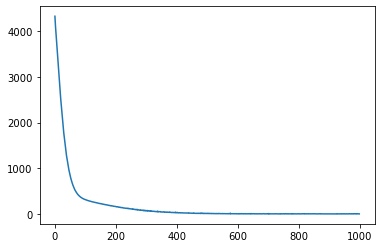

In [6]:
plt.plot(history.history['loss'])

In [7]:
for weights in model.get_weights():
    print('Weight/bias:', weights)

Weight/bias: [[2.964705 ]
 [2.0464761]]
Weight/bias: [[-2.6894343]
 [-3.2484155]]
Weight/bias: [-0.0306356]
Weight/bias: [-3.6639707]


In [8]:
y_predict = np.zeros((N_SAMPLES, N_DATA))
for i in trange(N_SAMPLES):
    y_predict[i] = model.predict(Xy.batch(N_DATA)).flatten()

100%|██████████| 1000/1000 [01:16<00:00, 13.14it/s]


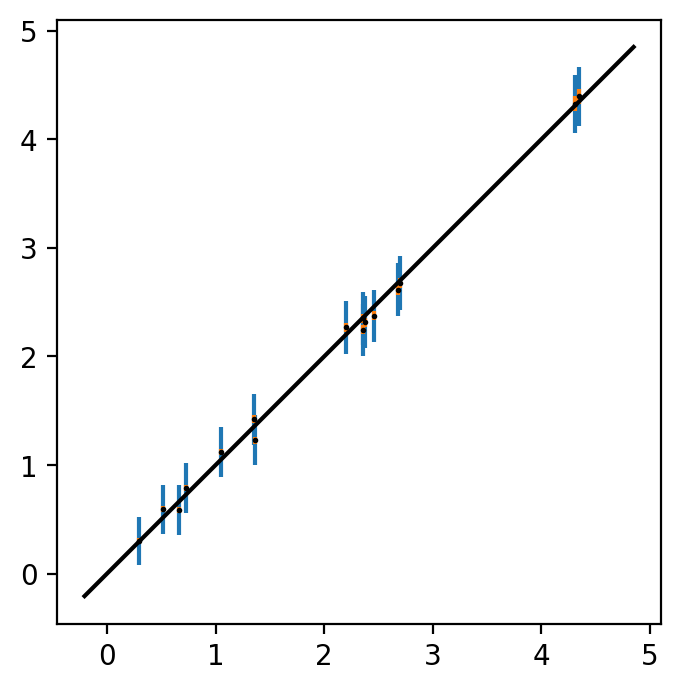

In [9]:
plt.figure(dpi=200)
plt.errorbar(y, y_predict.mean(0),
             yerr=y_predict.std(0) + 2*LIKELIHOOD_STDDEV, 
             linestyle='None', marker=None)

plt.errorbar(y, y_predict.mean(0),
             yerr=y_predict.std(0), 
             linestyle='None', marker='o', mec='k', ms=1)

plt.plot([y.min()-0.5, y.max()+0.5], [y.min()-0.5, y.max()+0.5], 'k')

plt.axis('square')


plt.show()

In [10]:
Xb = np.concatenate([X, np.ones((N_DATA, 1))], axis=1)
# Xb = X
Sigma_0 = PRIOR_STDDEV**2 * np.eye(Xb.shape[1])
Sigma_e = LIKELIHOOD_STDDEV**2 * np.eye(N_DATA)
Sigma_k = np.linalg.inv(np.linalg.inv(Sigma_0) + Xb.T @ Xb/LIKELIHOOD_STDDEV**2)
Mu_k = Sigma_k @ (Xb.T @ y/LIKELIHOOD_STDDEV**2)

In [11]:
Mu_k

array([[ 2.9611044 ],
       [ 2.06274995],
       [-0.03045692]])

In [12]:
print(model.get_weights()[0])
print(model.get_weights()[2])

[[2.964705 ]
 [2.0464761]]
[-0.0306356]


In [16]:
# Sigma_k

In [21]:
U, s, V = np.linalg.svd(Sigma_k)
print('Diag Sigma^0.5:', (U @ np.diag(s**0.5) @ V)[np.eye(3).astype(bool)])
# np.linalg.cholesky(Sigma_k)

Diag Sigma^0.5: [0.12209459 0.09819937 0.04308481]


In [22]:
print(np.log(np.exp(model.get_weights()[1]) + 1))
print(np.log(np.exp(model.get_weights()[3]) + 1))

[[0.06571224]
 [0.03810051]]
[0.02530764]
